#  Jupyter Notebooks  for Data Exploration and Machine Learning Experiments

After this talk you should know
- how to get started with Jupyter Notebooks
- How to explore data and plot graphs
- how to use a simple ML model and run inference tests

# What is Jupyter Notebook?

The Jupyter Notebook is an open-source web application that allows you to create and share documents that contain live code, equations, visualizations and narrative text. Uses include: 
- data cleaning and transformation, 
- numerical simulation, 
- statistical modeling, 
- data visualization, 
- machine learning, 
- and much more.

## How to install Jupyter on your laptop
Open Terminal
```python
mkdir jupyter-project
cd jupyter-project
virtualenv venv
. venv/bin/activate
pip install jupyter
jupyter notebook
```

after the session

```python
deactivate
```

### How to explore data and plot graphs
Let's get some data and start exploring
- example 1:  audio WAV file
- example 2:  CSV file 

## How to make slides

use this: 
```jupyter nbconvert Slides.ipynb --to slides --post serve```


In [1]:
# Uncomment next 2 lines to install required libraries
#!pip install -r requirements.txt
#!pip install sounddevice
#!pip install tensorflow

In [2]:
# Import libraries used in the following slides
from scipy.io import wavfile
from scipy.signal import butter, filtfilt, periodogram
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
from peakdetect import peakdet
import sounddevice as sd 
import cv2
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

In [3]:
# Introduction to Morse Code - this is how add pictures on your notebook
from IPython.display import HTML
HTML('<br><h2>Morse code</h2> <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b5/International_Morse_Code.svg/315px-International_Morse_Code.svg.png">')

Audio file duration:4 seconds, sample frequency:8000 Hz


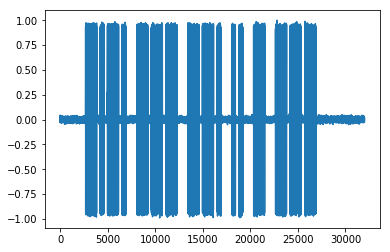

In [23]:
# Open audio WAV file containing Morse code and plot & play first 4 seconds 
Fs, signal = wavfile.read("cogito.wav")
dur = len(signal)/Fs
print("Audio file duration:{} seconds, sample frequency:{} Hz".format(dur, Fs))
_ = plt.plot(signal[0:4*Fs])
sd.play(signal[0:4*Fs], Fs)  #play first 4 seconds 

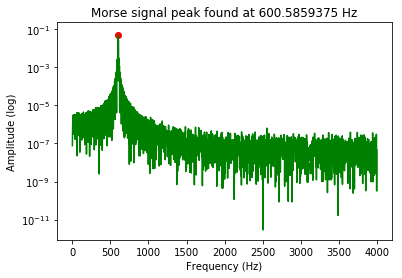

In [18]:
# Find the signal frequency and maximum value
def find_peak(fname):
    Fs, x = wavfile.read(fname)
    f,s = periodogram(x, Fs,'blackman',8192,'linear', False, scaling='spectrum')
    threshold = max(s)*0.9  # only 0.4 ... 1.0 of max value freq peaks included
    maxtab, mintab = peakdet(abs(s[0:int(len(s)/2-1)]),\
                             threshold,f[0:int(len(f)/2-1)] )
    plt.title("Morse signal peak found at {} Hz".format(maxtab[0,0]))
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude (log)")
    plt.yscale('log')
    _ = plt.plot(f[0:len(f)/2-1],abs(s[0:len(s)/2-1]),'g-')
    _ = plt.scatter(maxtab[:,0], maxtab[:,1], c='r') 
    plt.show()
    return maxtab[0,0]
tone = find_peak("cogito.wav")


### Ideal Mixer Formula
To demodulate the signal ω1 we multiply it with ω2. 
We get the envelope of the signal using a low pass filter to remove high frequency components. Here is the formula:


\begin{equation}
cos(ω1)cos(ω2)=\frac{cos(ω1+ω2)}{2} + \frac{cos(ω1−ω2)}{2}
\end{equation}

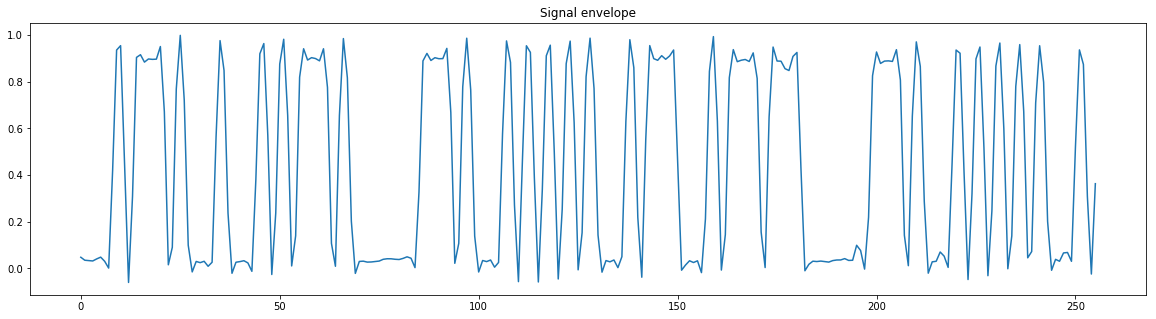

In [17]:
def demodulate(signal, Fs, tone):
    # demodulate 8 kHz audio signal by mixing with known CW tone and 
    # decimate down to 125 Hz
    t = np.arange(len(signal)) / float(Fs)
    mixed =  signal*((1 + np.sin(2*np.pi*tone*t))/2 ) 
    wn = 25./(Fs/2.)      # 25 Hz cut-off for lowpass filter
    b, a = butter(3, wn)  # let's use 3rd order butterworth filter
    z = filtfilt(b, a, abs(mixed))
    decimate = int(Fs/64) # 8000 Hz / 64 = 125 Hz => 8 msec / sample 
    o = z[0::decimate]/max(z)
    return o

envelope = demodulate(signal[0:(4*Fs)], Fs, tone)
plt.figure(figsize=(20,5))
plt.title("Signal envelope")
_ = plt.plot(envelope)

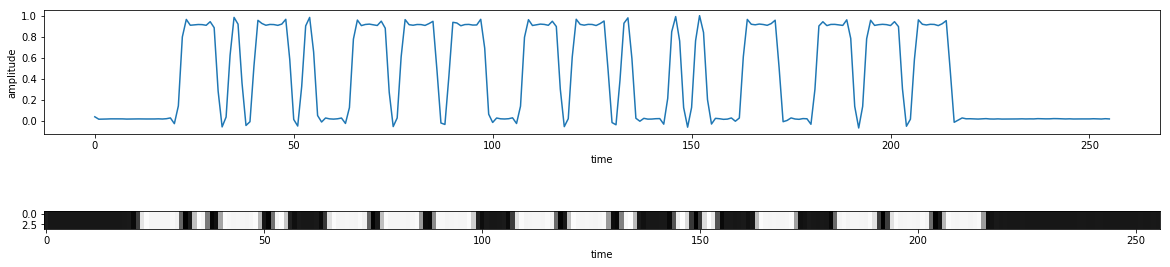

In [7]:
# Convert demodulated audio file into a picture 
def process_audio_file(fname,x,y, tone):
    Fs, signal = wavfile.read(fname)
    o = demodulate(signal[(Fs*x):Fs*(x+y)], Fs, tone)
    return o, len(signal)/Fs

o,dur = process_audio_file("cogito.wav",0,4, tone)
plt.figure(figsize=(20,5))
plt.subplot(2, 1, 1)
plt.plot(o[0::1])    # plot amplitude 
plt.ylabel('amplitude')
plt.xlabel('time')
plt.subplot(2, 1, 2)
im = o[0::1].reshape(1,256)
img = cv2.resize(im, (256,4), interpolation = cv2.INTER_AREA)
plt.imshow(img, cmap = cm.Greys_r)  # show amplitude converted into an image
plt.xlabel('time')
plt.show()

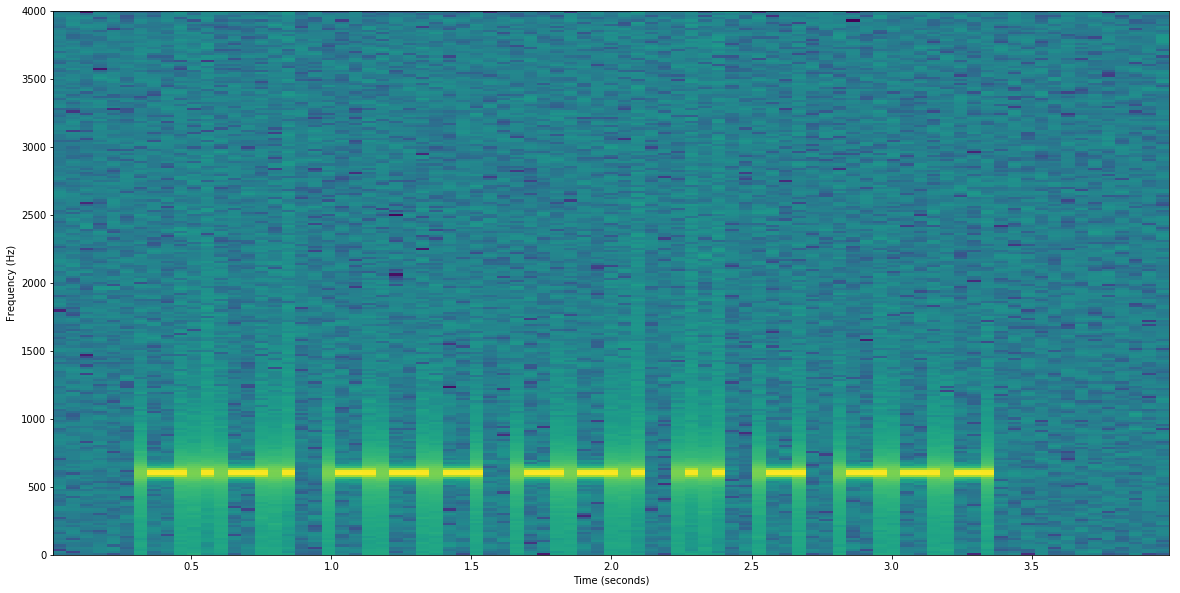

In [8]:
# Create a spectrogram - time/frequency representation
plt.figure(figsize=(20,10))
plt.ylabel("Frequency (Hz)")
plt.xlabel("Time (seconds)")
_ = plt.specgram(signal[0:4*Fs], NFFT=512, Fs=8000, Fc=0, mode='magnitude')

In [9]:
# Optional physics section - Ionospheric Layers
from IPython.display import HTML
HTML('<br><h2>Ionospheric Layers</h2> <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/7/7e/Ionosphere_Layers_en.svg/800px-Ionosphere_Layers_en.svg.png">')

In [10]:
# How to add YouTube videos in a notebook
# Shows the ionospheric layers at different altitudes refracting radio waves at HF frequencies
from IPython.display import HTML
HTML('<iframe width="600" height="400" src="https://www.youtube.com/embed/dp_2AHAK-Ec" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')



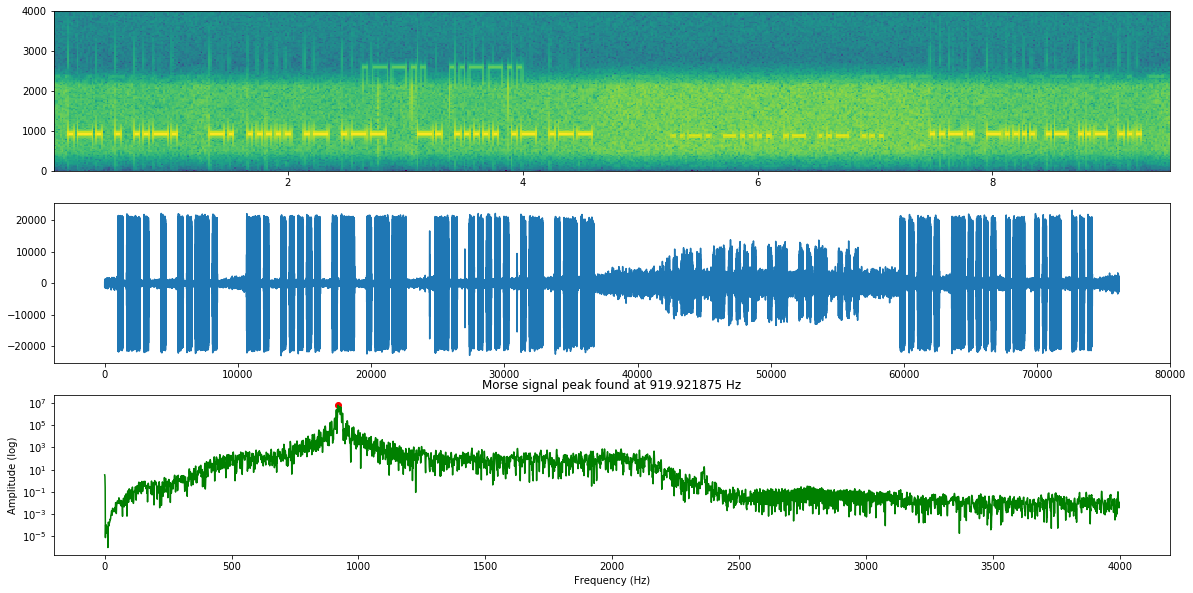

In [26]:
# Recorded Morse code audio from 7 MHz HF band - 3 different views
# Download audiofile from here: https://s3.amazonaws.com/alexia-skills/audio/realmorse2.wav
Fs, signal = wavfile.read("realmorse2.wav")
plt.figure(figsize=(20,10))
plt.subplot(3, 1, 1)
_ = plt.specgram(signal, NFFT=256, Fs=8000, Fc=0, mode='magnitude')
plt.subplot(3, 1, 2)
_ = plt.plot(signal)
plt.subplot(3, 1, 3)
tone = find_peak("realmorse2.wav")
plt.show()
sd.play(signal, Fs) 

# Machine Learning demo
The next slides show how to use a ML model to make inference. 
I have trained a CNN-LSTM-CTC model using ~ 5.2 hours of training audio clips with Morse code generated from a dictionary of random words. 

### Training 

```python MorseDecoder.py --experiments
['model.yaml']
SNR_DB:[40, 30, 20, 10, 6, 3, -3, -6, -8, -10]
completed 50000 files
...
...
Character error rate:  2.5%. Word accuracy: 93.8%.
numCharTotal:8642 numWordTotal:2000
Character error rate  2.5% not improved in last 5 epochs
No more improvement since 5 epochs. Training stopped.
Total training time was 2:57:30.122928
```

In [12]:
from MorseDecoder import find_peak, process_audio_file, Batch

def signal_envelope_to_image(envelope, imgSize):
    image = envelope[0::1].reshape(1,256)
    img = cv2.resize(image*256., imgSize, interpolation = cv2.INTER_AREA)
    cv2.imwrite("imgname.png",img)
    # transpose for TF
    im = cv2.transpose(img)
    # normalize
    (m, s) = cv2.meanStdDev(im)
    m = m[0][0]
    s = s[0][0]
    im = im - m
    im = im / s if s>0 else im
    return im, img 
        
def infer_morse_code(model, fileName):
    sampleLen = 4 # take <sample> seconds from audio file
    startPos = 0  # start position in seconds
    tone = find_peak(fileName)
    envelope,duration = process_audio_file(fileName, startPos, sampleLen, tone)
    panels = int(duration/sampleLen)+1  # how many display panels in subplot
    print('audio file duration:{} seconds'.format(duration))
    plt.figure(figsize=(20,20))
    while startPos < (duration - sampleLen):
        im, img = signal_envelope_to_image(envelope, model.imgSize)
        batch = Batch(None, [im])
        startTime = datetime.datetime.now()
        (recognized, probability) = model.inferBatch(batch, True)
        stopTime = datetime.datetime.now()  # measure inference time
        if probability[0] > 0.0005 and (startPos+1 <=panels):
            plt.subplot(panels, 1, startPos+1)
            plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
            plt.imshow(img, cmap = cm.Greys_r)
            plt.title("startpos:{} txt:{} prob:{:3.2f} Ti:{}".format(startPos, recognized[0], probability[0], stopTime-startTime))
        startPos += 1
        envelope,duration = process_audio_file(fileName, startPos, sampleLen, tone)
    plt.show()

Python: 2.7.10 (default, Aug 17 2018, 19:45:58) 
[GCC 4.2.1 Compatible Apple LLVM 10.0.0 (clang-1000.0.42)]
Tensorflow: 1.13.1
Init with stored values from model-snr-40--10/snapshot-20
INFO:tensorflow:Restoring parameters from model-snr-40--10/snapshot-20


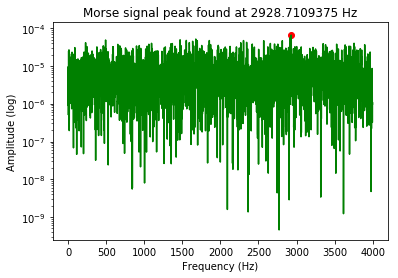

audio file duration:8.56 seconds


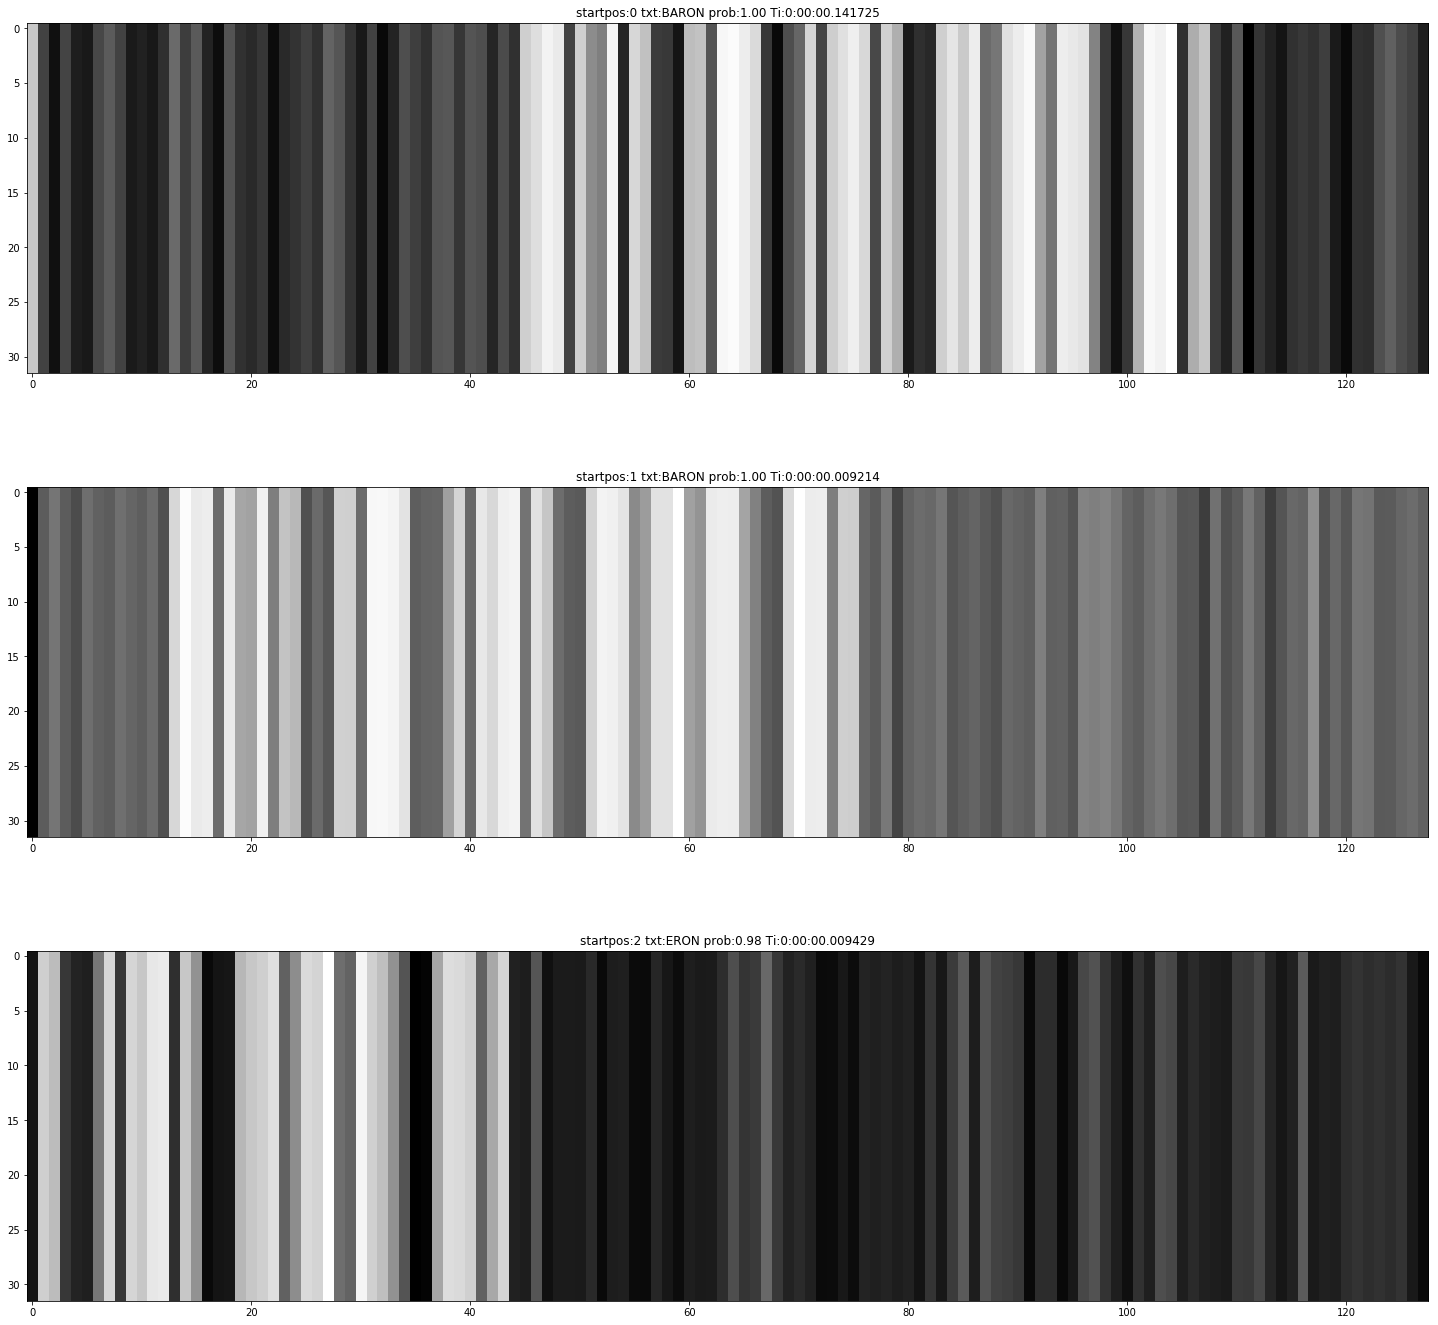

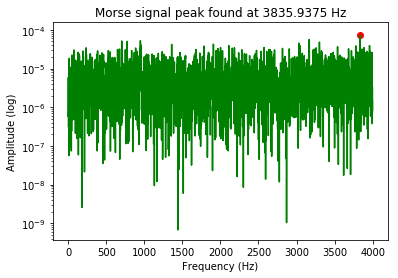

audio file duration:8.56 seconds


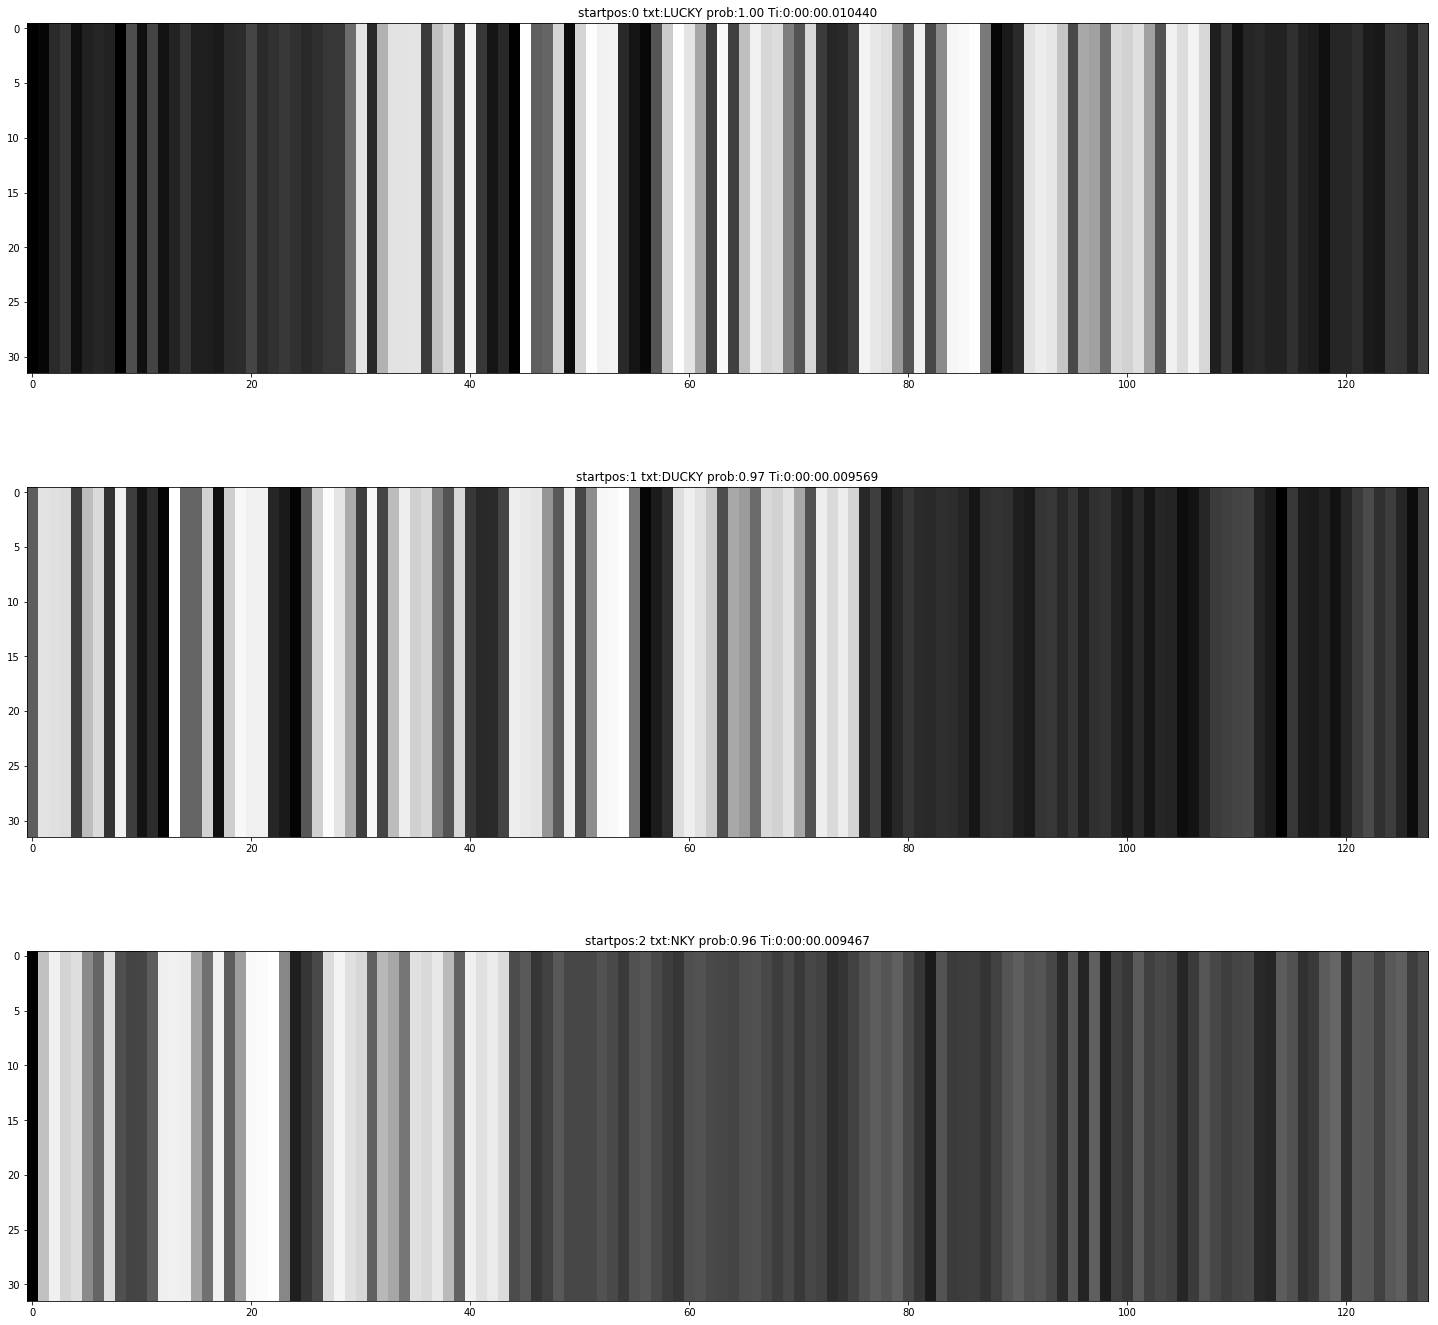

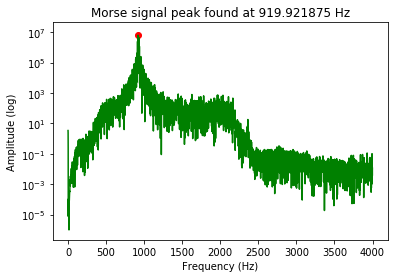

audio file duration:9.52025 seconds


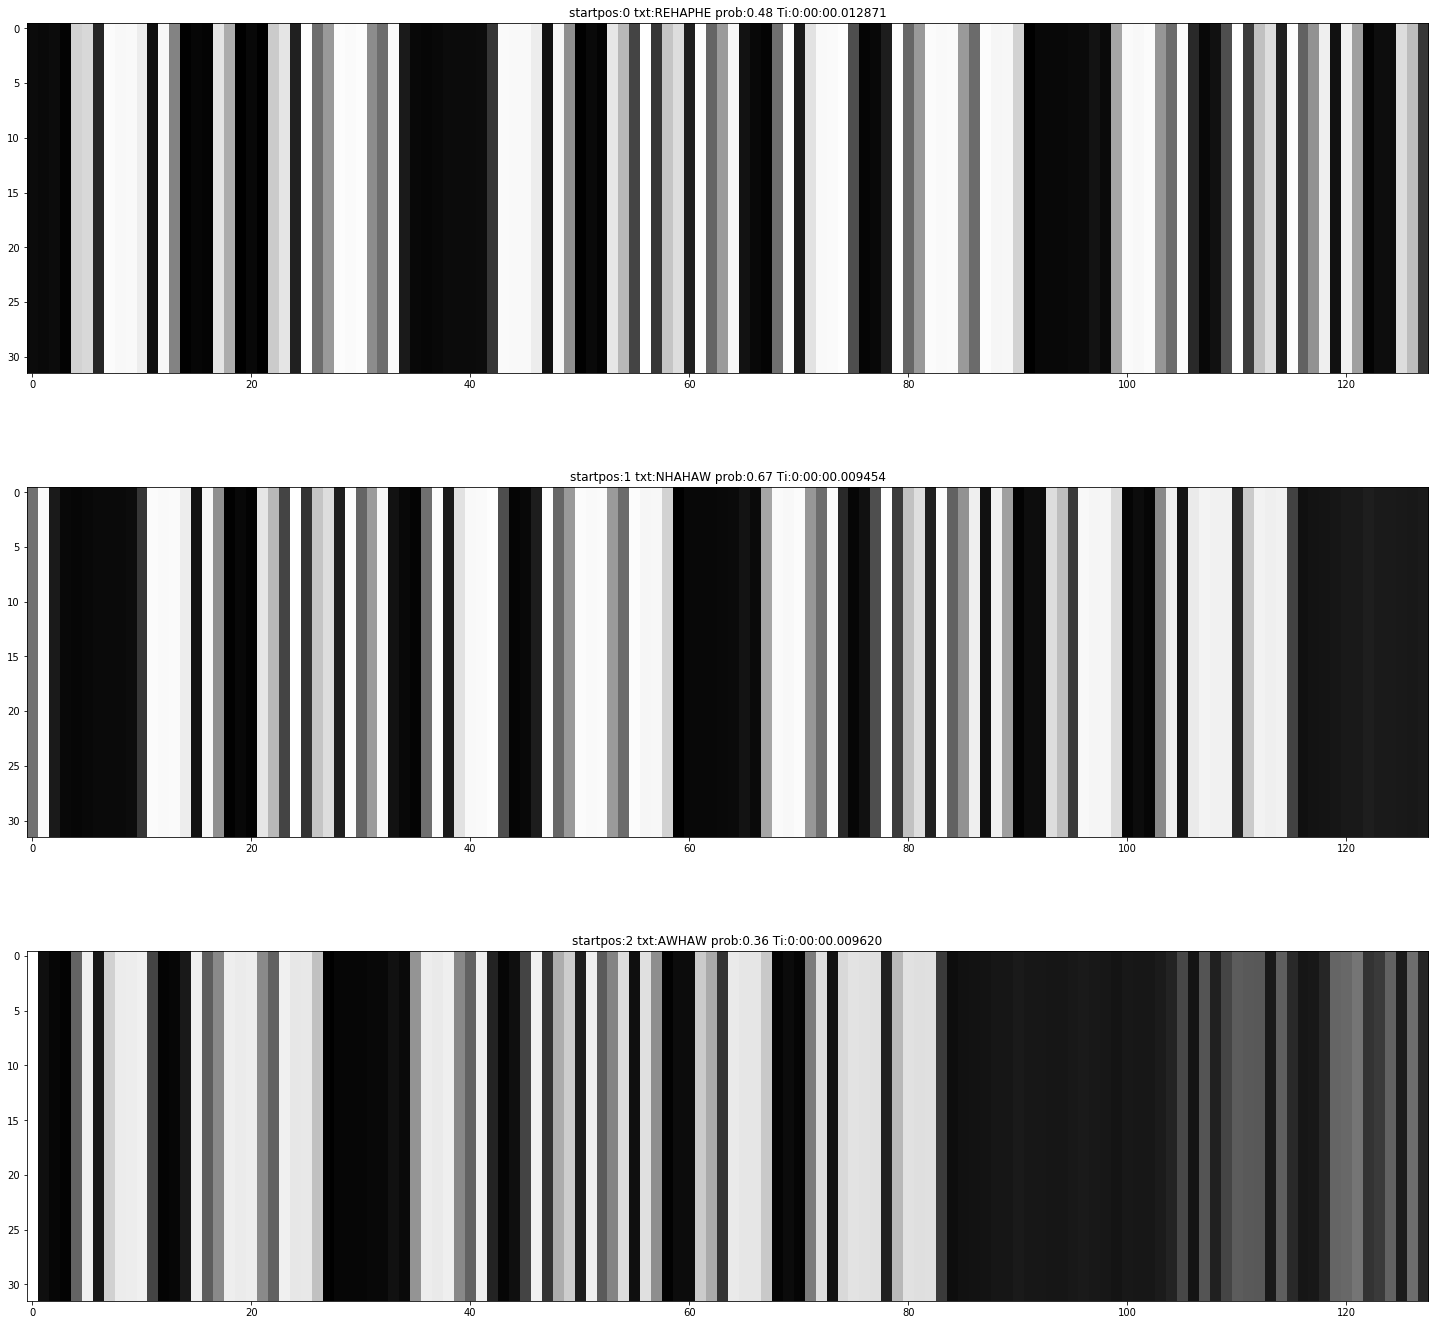

should be: REF N5AW N5AW F6AUS F6AUS


In [19]:
from MorseDecoder import Config, Model, DecoderType
import tensorflow as tf
import datetime

tf.reset_default_graph()
config = Config('model.yaml')
model = Model(open('morseCharList.txt').read(), config, DecoderType.BestPath, mustRestore=True)
_ = infer_morse_code(model, "model-snr-40--10/SNR-8WPM30-BARON-48fc17e094eb42e58193b9e2f8b346c5.wav")
_ = infer_morse_code(model, "model-snr-40--10/SNR-6WPM30-LUCKY-b07e51e13b9f44ed98da820f341375ae.wav")
_ = infer_morse_code(model, "realmorse2.wav")
print("should be: REF N5AW N5AW F6AUS F6AUS")

### How to explore data and plot graphs
Let's get some data and start exploring
- example 2:  read CSV file using pandas 

In [14]:
# Visualize Iris dataset 
import pandas as pd
url = 'https://gist.githubusercontent.com/curran/a08a1080b88344b0c8a7/raw/d546eaee765268bf2f487608c537c05e22e4b221/iris.csv'
data = pd.read_csv(url)
data.head(5)

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


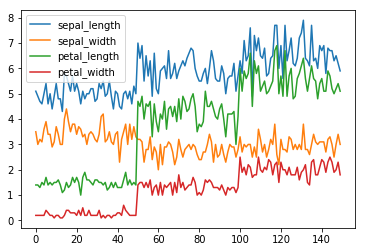

In [15]:
# Visualize Iris dataset - lineplot example
_ = data.plot()

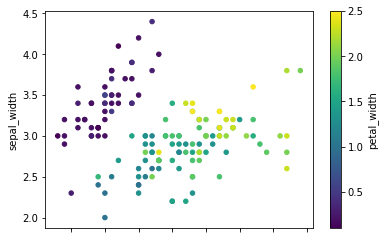

In [16]:
# Visualize Iris dataset - scatter plot example 
_ = data.plot.scatter(x='sepal_length', y='sepal_width', c='petal_width', colormap='viridis')

## References
 1. Jupyter https://www.datacamp.com/community/tutorials/tutorial-jupyter-notebook
 2. Morse http://ag1le.blogspot.com/2019/02/training-computer-to-listen-and-decode.html
 3. Pandas https://pandas.pydata.org/pandas-docs/stable/getting_started/index.html
 4. Matplotlib https://matplotlib.org/index.html